In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import sys, os, time, csv, glob, cv2

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn import metrics

## Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

Using plaidml.keras.backend backend.


In [2]:
train_normal = []
train_attack = []
test_normal = []
test_attack = []

for i in glob.glob('/Users/ryan/NSL CNN/2d-cnn/split_images/60-40/train_normal/train_normal_*.jpg', recursive=True):
    train_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for j in glob.glob('/Users/ryan/NSL CNN/2d-cnn/split_images/60-40/train_attack/train_attack_*.jpg', recursive=True):
    train_attack.append(cv2.imread(j, cv2.IMREAD_GRAYSCALE))

for k in glob.glob('/Users/ryan/NSL CNN/2d-cnn/split_images/60-40/test_normal/test_normal_*.jpg', recursive=True):
    test_normal.append(cv2.imread(k, cv2.IMREAD_GRAYSCALE))

for l in glob.glob('/Users/ryan/NSL CNN/2d-cnn/split_images/60-40/test_attack/test_attack_*.jpg', recursive=True):
    test_attack.append(cv2.imread(l, cv2.IMREAD_GRAYSCALE))

train_normal = np.array(train_normal)
train_attack = np.array(train_attack)
test_normal = np.array(test_normal)
test_attack = np.array(test_attack)

In [3]:
np.shape(train_normal), np.shape(train_attack), np.shape(test_normal), np.shape(test_attack)

# for i in range(0, 2):
#   plt.imshow(train_normal[i], cmap = 'gray')
#   plt.show()

# for i in train_normal:
#   print(i)


## MORE NORMAL DATA FOR TESTING TO GET SAME RATIO

((2570, 64, 64), (2364, 64, 64), (2570, 64, 64), (1576, 64, 64))

In [4]:
## augmenting the data to create more images
## only run cell if needed

## vertically flip training images
vert_flip_train_attack = np.fliplr(train_attack)
vert_flip_train_normal = np.fliplr(train_normal)

## flip training images horizonatally
hor_flip_train_attack = np.rot90(train_attack, axes = (1,2), k = 2)
hor_flip_train_normal = np.rot90(train_normal, axes = (1,2), k = 2)

## rotate training images left and right once each
rotate90l_train_attack = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_attack = np.rot90(train_normal, -1, axes=(1, 2))
rotate90l_train_normal = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_normal = np.rot90(train_normal, -1, axes=(1, 2))



## vertically flip testing images
vert_flip_test_attack = np.fliplr(test_attack)
vert_flip_test_normal = np.fliplr(test_normal)

## flip testing images horizonatally
hor_flip_test_attack = np.rot90(test_attack, axes = (1,2), k = 2)
hor_flip_test_normal = np.rot90(test_normal, axes = (1,2), k = 2)

## rotate testing images left and right once each
rotate90l_test_attack = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_attack = np.rot90(test_normal, -1, axes=(1, 2))
rotate90l_test_normal = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_normal = np.rot90(test_normal, axes=(1, 2))


## stack all the original and augmented data to one single numpy array
train = np.vstack((train_attack, vert_flip_train_attack, hor_flip_train_attack, rotate90l_train_attack, rotate90r_train_attack,
                   train_normal, vert_flip_train_normal, hor_flip_train_normal, rotate90l_train_normal, rotate90r_train_normal))
test = np.vstack((test_attack, vert_flip_test_attack, hor_flip_test_attack, rotate90l_test_attack, rotate90r_test_attack,
                  test_normal, vert_flip_test_normal, hor_flip_test_normal, rotate90l_test_normal, rotate90r_test_normal))

## without rotate data
# train = np.vstack((train_attack, vert_flip_train_attack, hor_flip_train_attack,
#                    train_normal, vert_flip_train_normal, hor_flip_train_normal))
# test = np.vstack((test_attack, vert_flip_test_attack, hor_flip_test_attack,
#                   test_normal, vert_flip_test_normal, hor_flip_test_normal, rotate90l_test_normal, rotate90r_test_normal))                  

In [5]:
## if no augmented data is needed, run this cell
train = np.vstack((train_attack, train_normal))
test = np.vstack((test_attack, test_normal))

train.shape, test.shape

((6580, 64, 64), (4216, 64, 64))

In [5]:
train = train.reshape(-1,64,64,1)
test = test.reshape(-1,64,64,1)

train.shape, test.shape

((24670, 64, 64, 1), (20730, 64, 64, 1))

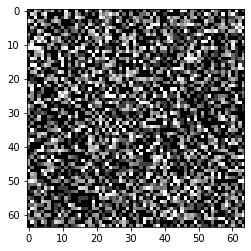

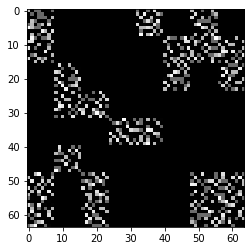

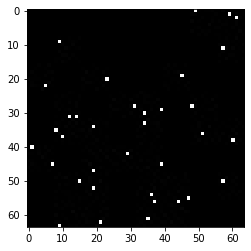

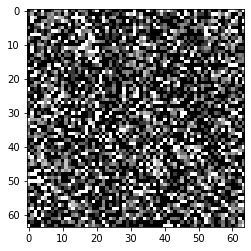

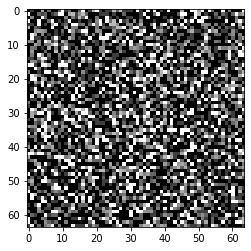

In [7]:
for i in range(0, 5):
    plt.imshow(train[i], cmap = 'gray')
    plt.show()

In [ ]:
print(f'Number of training images: {train.shape[0]}\nNumber of testing images {test.shape[0]}\n')
print(f'Number of training attack: {train_attack.shape[0]}\nNumber of vert flip train attack: {vert_flip_train_attack.shape[0]}\nNumber of training normal: {train_normal.shape[0]}\nNumber of vert flip training normal: {vert_flip_train_normal.shape[0]}\n')

print(f'Number of testing attack: {test_attack.shape[0]}\nNumber of vert flip test attack: {vert_flip_test_attack.shape[0]}\nNumber of hor flip test attack: {hor_flip_test_attack.shape[0]}\nNumber of test normal: {test_normal.shape[0]}\nNumber of vert flip test normal: {vert_flip_test_normal.shape[0]}\n' +
    f'Number of hor flip test normal: {hor_flip_test_normal.shape[0]}\nNumber of rotate90 left test normal: {rotate90l_test_normal.shape[0]}\nNumber of rotate90 right test normal: {rotate90r_test_normal.shape[0]}')

In [9]:
## create the training and testing data labels
## run if not using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [6]:
## create the training and testing data labels
## run this cell if using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [20]:
## create the training and testing data labels
## run this cell if using augmented data but not with rotated data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0]):
    training_labels.append('attack')
a
## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_train_normal.shape[0] + rotate90r_train_normal.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_train_normal.shape[0] + rotate90r_train_normal.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [7]:
## create the dataframe for labels, then OHE the column
ytrain = pd.DataFrame(training_labels, columns = ['category'])
ytest = pd.DataFrame(testing_labels, columns = ['category'])

ytrain = pd.get_dummies(ytrain['category'])
ytest = pd.get_dummies(ytest['category'])

ytrain, ytest

(       attack  normal
 0           1       0
 1           1       0
 2           1       0
 3           1       0
 4           1       0
 ...       ...     ...
 24665       0       1
 24666       0       1
 24667       0       1
 24668       0       1
 24669       0       1
 
 [24670 rows x 2 columns],
        attack  normal
 0           1       0
 1           1       0
 2           1       0
 3           1       0
 4           1       0
 ...       ...     ...
 20725       0       1
 20726       0       1
 20727       0       1
 20728       0       1
 20729       0       1
 
 [20730 rows x 2 columns])

In [8]:
## shuffle the data to prevent pattern recognition
train, ytrain = sklearn.utils.shuffle(train, ytrain, random_state = 7)
test, ytest = sklearn.utils.shuffle(test, ytest, random_state = 7)

In [10]:
KERNEL_SIZE = [2,2]
IMAGE_SIZE = [64,64,1]

cnn = Sequential()

## convolution 1
cnn.add(Conv2D(2**4, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 2
cnn.add(Conv2D(2**5, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 3
cnn.add(Conv2D(2**6, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 4
cnn.add(Conv2D(2**7, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 5
# cnn.add(Conv2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# # cnn.add(Dropout(0.5))

# ## convolution 6
# cnn.add(Conv2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

cnn.add(Flatten())

## dense
# cnn.add(Dense(256, activation='relu'))
cnn.add(Dense(128, activation='relu'))
# cnn.add(Dense(64, activation='relu'))
# cnn.add(Dense(256, activation='relu'))
# cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation = 'sigmoid'))

# callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
            metrics = ['accuracy'])


cnn.summary()

INFO:plaidml:Opening device "metal_amd_radeon_pro_555x.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         32896     
__________

In [11]:
start = time.time()
model_history = cnn.fit(train, ytrain, batch_size = 512, epochs = 300)
end = time.time()

os.system(f'say "training finished in {round(end - start, 2)} seconds"')
print(f'Training finished in {round(end - start, 2)}')

Epoch 1/300
24670/24670 [==============================] - 14s 584us/step - loss: 4.6537 - acc: 0.5295
Epoch 2/300
24670/24670 [==============================] - 10s 402us/step - loss: 0.6884 - acc: 0.5790
Epoch 3/300
24670/24670 [==============================] - 10s 402us/step - loss: 0.6644 - acc: 0.5987
Epoch 4/300
24670/24670 [==============================] - 10s 402us/step - loss: 0.6598 - acc: 0.6061
Epoch 5/300
24670/24670 [==============================] - 10s 403us/step - loss: 0.6572 - acc: 0.6091
Epoch 6/300
24670/24670 [==============================] - 10s 400us/step - loss: 0.6548 - acc: 0.6128
Epoch 7/300
24670/24670 [==============================] - 10s 399us/step - loss: 0.6511 - acc: 0.6187
Epoch 8/300
24670/24670 [==============================] - 10s 400us/step - loss: 0.6474 - acc: 0.6226
Epoch 9/300
24670/24670 [==============================] - 10s 399us/step - loss: 0.6429 - acc: 0.6274
Epoch 10/300
24670/24670 [==============================] - 10s 399us/ste

dict_keys(['loss', 'acc'])


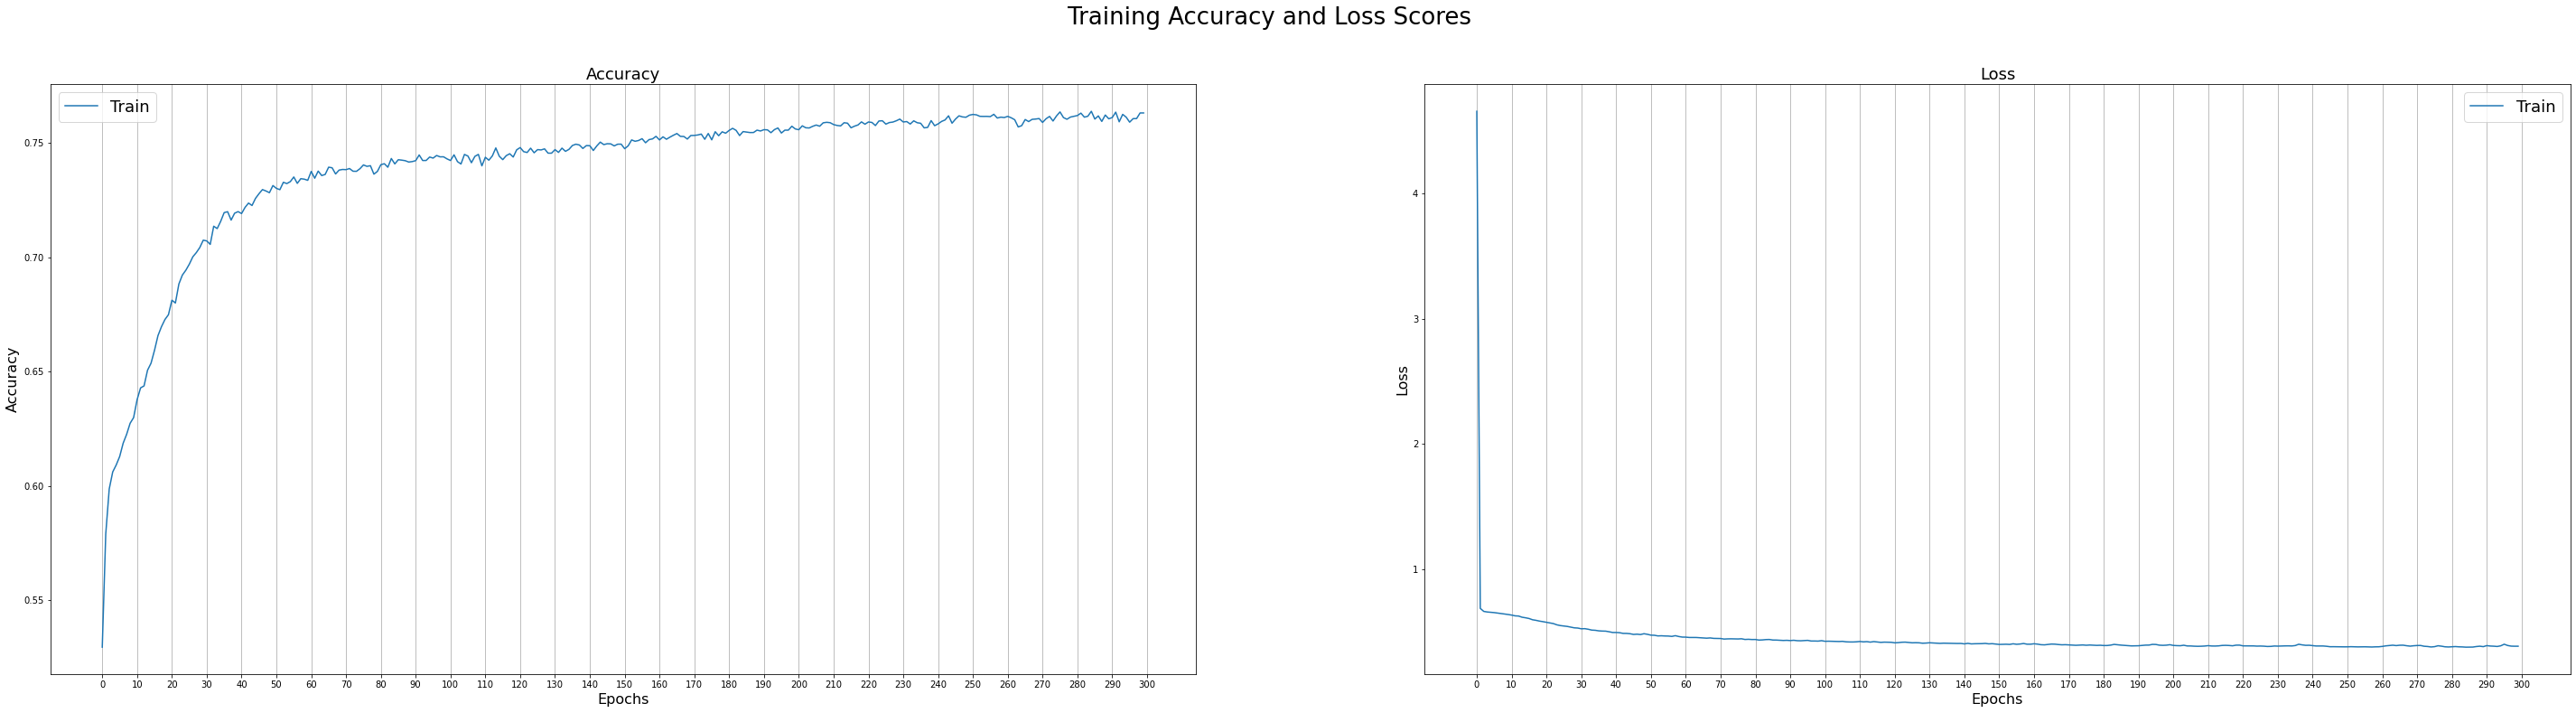

In [12]:
print(model_history.history.keys())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50,12))
fig.suptitle('Training Accuracy and Loss Scores', fontsize = 26)

axes[0].plot(model_history.history['acc'])
axes[0].set_title('Accuracy', fontsize = 18)
axes[0].set_ylabel('Accuracy', fontsize = 16)
axes[0].set_xlabel('Epochs', fontsize = 16)
axes[0].set_xticks(np.arange(0, 310, step = 10))
axes[0].grid(axis = 'x')
axes[0].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

axes[1].plot(model_history.history['loss'])
axes[1].set_title('Loss', fontsize = 18)
axes[1].set_ylabel('Loss', fontsize = 16)
axes[1].set_xlabel('Epochs', fontsize = 16)
axes[1].set_xticks(np.arange(0, 310, step = 10))
axes[1].grid(axis = 'x')
axes[1].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

In [13]:
loss, acc = cnn.evaluate(test, ytest, batch_size = 512, verbose = 0)
print(f'Loss = {round(loss, 4)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 0.8163	Accuracy = 67.28%


In [14]:
preds = cnn.predict(test)
y_preds = np.argmax(preds, axis = 1)

preds[:20]

array([[0.00021, 0.99979],
       [0.03575, 0.9642 ],
       [0.0003 , 0.9997 ],
       [0.35345, 0.64657],
       [0.35345, 0.64657],
       [0.94291, 0.05707],
       [0.00945, 0.99052],
       [0.35345, 0.64657],
       [0.49811, 0.50189],
       [0.0183 , 0.98167],
       [0.35345, 0.64657],
       [0.00029, 0.99971],
       [0.     , 1.     ],
       [0.35345, 0.64657],
       [0.35345, 0.64657],
       [0.21913, 0.77886],
       [0.35345, 0.64657],
       [0.00236, 0.99764],
       [0.35345, 0.64657],
       [0.35345, 0.64657]], dtype=float32)

In [15]:
def build_classifier():
    
    cnn = Sequential()

    ## convolution 1
    cnn.add(Conv2D(2**4, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 2
    cnn.add(Conv2D(2**5, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 3
    cnn.add(Conv2D(2**6, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 4
    cnn.add(Conv2D(2**7, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))
    
    ## convolution 4
#     cnn.add(Conv2D(2**6, (KERNEL_SIZE), padding="same", activation='relu'))
#     cnn.add(MaxPooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    ## dense
#     cnn.add(Dense(256, activation='relu'))
    cnn.add(Dense(128, activation='relu'))
#     cnn.add(Dense(128, activation='relu'))
#     cnn.add(Dense(64, activation='relu'))
#     cnn.add(Dropout(0.5))
    cnn.add(Dense(2, activation = 'sigmoid'))

    # callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

    cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
                metrics = ['accuracy'])
    
    return cnn

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 512, epochs = 300)

In [16]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, random_state = None)
score = cross_val_score(classifier, test, ytest, cv = kf)
print(f'Model Cross Validation: \n{round(score.mean(), 3)*100}%')
print(f'Model Cross Validation: \n{score}')

os.system('say "cross validation finished"')

Epoch 1/300
16584/16584 [==============================] - 11s 643us/step - loss: 4.2272 - acc: 0.5406
Epoch 2/300
16584/16584 [==============================] - 7s 402us/step - loss: 2.1926 - acc: 0.5712
Epoch 3/300
16584/16584 [==============================] - 7s 402us/step - loss: 0.6761 - acc: 0.5854
Epoch 4/300
16584/16584 [==============================] - 7s 402us/step - loss: 0.6629 - acc: 0.5973
Epoch 5/300
16584/16584 [==============================] - 7s 402us/step - loss: 0.6591 - acc: 0.6052
Epoch 6/300
16584/16584 [==============================] - 7s 400us/step - loss: 0.6558 - acc: 0.6123
Epoch 7/300
16584/16584 [==============================] - 7s 400us/step - loss: 0.6515 - acc: 0.6195
Epoch 8/300
16584/16584 [==============================] - 7s 401us/step - loss: 0.6471 - acc: 0.6310
Epoch 9/300
16584/16584 [==============================] - 7s 402us/step - loss: 0.6426 - acc: 0.6379
Epoch 10/300
16584/16584 [==============================] - 7s 401us/step - loss:

0